In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Sentiment analysis, also known as opinion mining, is a technique used in natural language processing (NLP) to identify and extract subjective information from text data. Its main objective is to determine the polarity of sentiments expressed in a given text, whether they are positive, negative, or neutral.

Businesses can leverage sentiment analysis to analyze customer feedback, product reviews, social media posts, and other types of text data to gain insights into the attitudes, opinions, and emotions of individuals towards their products, services, or brand. By identifying areas for improvement and highlighting areas of strength, sentiment analysis helps businesses make data-driven decisions, enhance customer satisfaction, and improve brand reputation.

To perform sentiment analysis, various techniques such as rule-based systems, machine learning algorithms, and deep learning models can be used. The choice of technique depends on the complexity of the text data and the specific use case. In recent years, machine learning-based approaches have become more popular due to their ability to handle large volumes of text data and achieve high accuracy in sentiment classification.

Overall, sentiment analysis is a powerful tool that helps businesses gain valuable insights into customer feedback and opinions. By utilizing these insights, businesses can make informed decisions and take actions that lead to better customer experiences and overall success.

In [50]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


import string
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from nltk.stem import WordNetLemmatizer

In [3]:
train = pd.read_csv('/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv')
test = pd.read_csv('/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv')
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
train.isnull().any()
test.isnull().any()

id       False
tweet    False
dtype: bool

In [17]:
dcol = ["label","id","date","flag","user","tweet"]
den = "ISO-8859-1"
train = pd.read_csv("/kaggle/input/twitter-tweets/Sentiment_Analysis_Tweets_Data.csv", names=dcol,encoding=den) 
train.head(5)

,label,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [18]:
train.dtypes

label     int64
id        int64
date     object
flag     object
user     object
tweet    object
dtype: object

In [19]:
train['label'] = train['label'].replace(4,1)

# Data Preprocessing

In [20]:
train['tweet'] = train['tweet'].str.lower()
#test['tweet'] = test['tweet'].str.lower()
train.head(5)

,label,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan i dived many times for the ball. man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [21]:
#Remove URLs
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
train['tweet'] =train['tweet'].apply(lambda x: cleaning_URLs(x))
train.head(5)

,label,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,@switchfoot s a bummer. you shoulda got davi...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan i dived many times for the ball. man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [23]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [24]:
#remove all stopwords
SW = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in SW])
train['tweet'] =train['tweet'].apply(lambda text: cleaning_stopwords(text))
train.head(5)

,label,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,@switchfoot bummer. shoulda got david carr thi...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset can't update facebook texting it... migh...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan dived many times ball. managed save ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving all. i'..."


In [25]:
#remove ponctuation
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
train['tweet'] =train['tweet'].apply(lambda x: cleaning_punctuations(x))
train.head(5)

,label,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot bummer shoulda got david carr third...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting it might cr...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many times ball managed save 50...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving all im mad...


In [26]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
train['tweet'] =train['tweet'].apply(lambda x: cleaning_repeating_char(x))
train.head(5)

,label,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot bummer shoulda got david carr third...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting it might cr...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many times ball managed save 50...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving all im mad...


In [29]:
#Remove numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
train['tweet'] =train['tweet'].apply(lambda x: cleaning_numbers(x))
train.head(5)

,label,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot bummer shoulda got david carr third...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting it might cr...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many times ball managed save r...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving all im mad...


In [30]:
#stemming
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
train['tweet'] =train['tweet'].apply(lambda x: stemming_on_text(x))
train.head(5)

,label,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot bummer shoulda got david carr third...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting it might cr...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many times ball managed save r...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving all im mad...


In [13]:
train.head()

,label,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot httptwitpiccomzl a s bummer should...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting it might cr...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many times ball managed save r...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving all im mad...


# Data 

In [35]:
#Split data
X = train.tweet
y = train.label
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =42)

In [ ]:
le = LabelEncoder()
df['LABEL'] = le.fit_transform(df['LABEL'])

<AxesSubplot: xlabel='label', ylabel='count'>

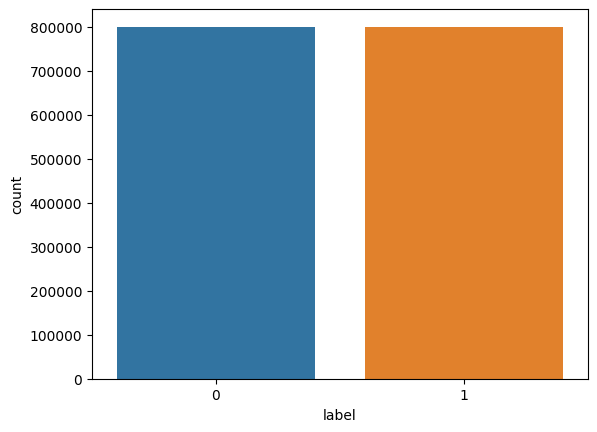

In [36]:
sns.countplot(x='label', data=train)

# Exploratory data analysis

0    800000
1    800000
Name: label, dtype: int64


<AxesSubplot: >

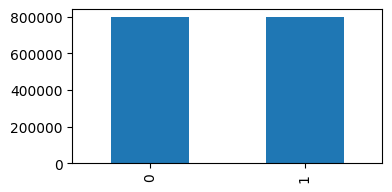

In [37]:
print(train['label'].value_counts())
train['label'].value_counts().plot.bar(figsize = (4,2))

In [38]:
train.groupby('label').describe()

id                                                          \
          count          mean           std           min           25%   
label                                                                     
0      800000.0  2.049457e+09  2.025848e+08  1.467810e+09  1.971571e+09   
1      800000.0  1.948178e+09  1.696291e+08  1.467822e+09  1.879943e+09   

                                                 
                50%           75%           max  
label                                            
0      2.057298e+09  2.220801e+09  2.329206e+09  
1      1.985419e+09  2.054322e+09  2.193602e+09

Training data is highly imbbalance as we have only 2242 tweets with positive and 29720 with negative sentiments. Lets cehck out some off the tweets with negative and positive

In [39]:
train[train['label'] == 0].head(10)

,label,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot bummer shoulda got david carr third...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting it might cr...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many times ball managed save r...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving all im mad...
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,kwesidei not whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,loltrish hey long time no see yes rains bit on...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,tatianak nope didnt
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,twittera que muera


In [40]:
train[train['label'] == 1].head(10)

,label,id,date,flag,user,tweet
800000,1,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,love healthuandpets u guys r best
800001,1,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting one besties tonight cant wait girl...
800002,1,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,darealsunisakim thanks twitter add sunisa got ...
800003,1,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,sick really cheap hurts much eat real food plu...
800004,1,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,lovesbrooklyn effect everyone
800005,1,1467822391,Mon Apr 06 22:22:47 PDT 2009,NO_QUERY,ajarofalmonds,productoffear tell burst laughing really loud ...
800006,1,1467822447,Mon Apr 06 22:22:51 PDT 2009,NO_QUERY,vmdavinci,rkeithhill thans response ihad already find an...
800007,1,1467822465,Mon Apr 06 22:22:48 PDT 2009,NO_QUERY,jessicavaliyi,keepinupwkris jealous hope great time vegas li...
800008,1,1467822489,Mon Apr 06 22:22:49 PDT 2009,NO_QUERY,emmasaur28,tommcfly ah congrats mr fletcher finally joini...
800009,1,1467822496,Mon Apr 06 22:22:49 PDT 2009,NO_QUERY,SherylBreuker,evoip responded stupid cat helping type forgiv...


adding a length column to thhe tweet

In [41]:
train['len'] = train['tweet'].str.len()
#test['len'] = test['tweet'].str.len()

train.head(10)

,label,id,date,flag,user,tweet,len
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot bummer shoulda got david carr third...,55
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting it might cr...,77
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many times ball managed save r...,59
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire,32
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving all im mad...,71
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,kwesidei not whole crew,23
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need hug,8
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,loltrish hey long time no see yes rains bit on...,79
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,tatianak nope didnt,19
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,twittera que muera,19


<AxesSubplot: ylabel='Frequency'>

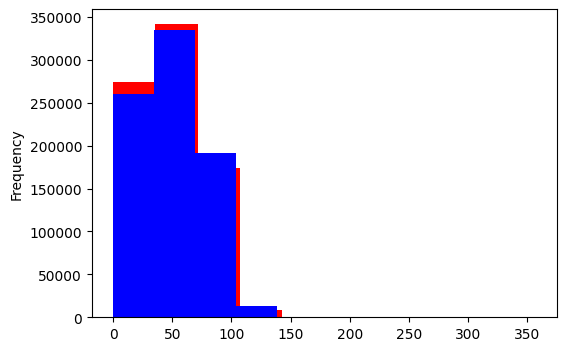

In [42]:
# length of negative and positive comment
len_pos = train[train['label'] == 1]
len_neg = train[train['label'] == 0]
len_pos['tweet'].str.len().plot.hist(color = 'red', figsize = (6, 4))
len_neg['tweet'].str.len().plot.hist(color = 'blue', figsize = (6, 4))


In [43]:
len_pos

,label,id,date,flag,user,tweet,len
800000,1,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,love healthuandpets u guys r best,33
800001,1,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting one besties tonight cant wait girl...,51
800002,1,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,darealsunisakim thanks twitter add sunisa got ...,78
800003,1,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,sick really cheap hurts much eat real food plu...,65
800004,1,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,lovesbrooklyn effect everyone,29
...,...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,woke up no school best feeling ever,35
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdbcom cool hear old walt interviews â«,44
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,ready mojo makeover ask details,31
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy th birthday boo alll time tupac amaru sh...,50


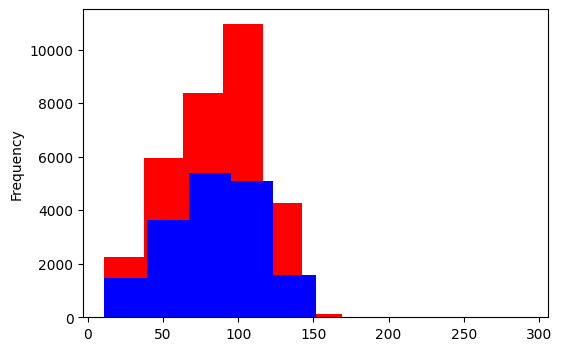

In [16]:
#checking the distribution of tweets in the data

length_train = train['tweet'].str.len().plot.hist(color = 'red', figsize = (6, 4))
length_test = test['tweet'].str.len().plot.hist(color = 'blue', figsize = (6, 4))

So the lengthh of tweets is very diffferent in test and training data

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

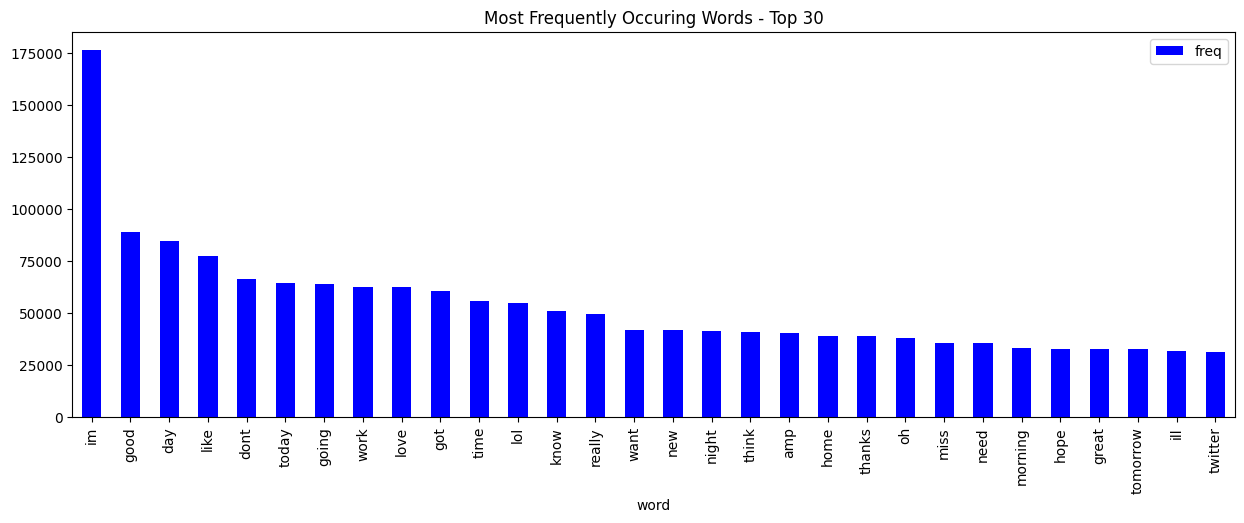

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 5), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

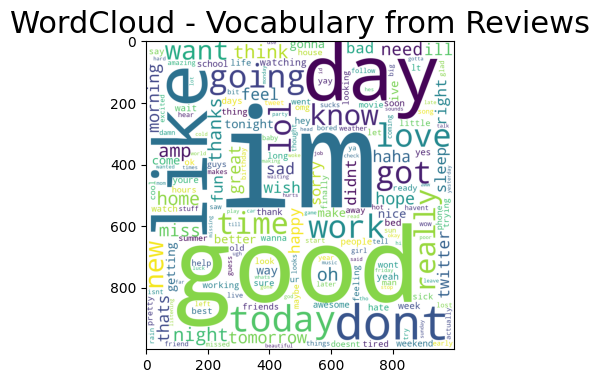

In [45]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(6,4))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

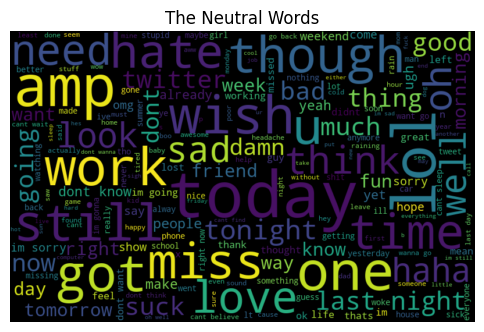

In [46]:
normal_words =' '.join([text for text in train['tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

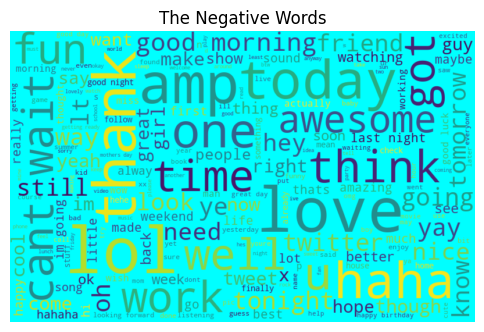

In [47]:
negative_words =' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(background_color = 'cyan', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state =42,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1440000,), (160000,), (1440000,), (160000,))

In [52]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
vectoriser.fit(X_train)



TfidfVectorizer(max_features=50000, ngram_range=(1, 2))

In [53]:
print('No. of feature_words: ', len(vectoriser))

TypeError: object of type 'TfidfVectorizer' has no len()

In [54]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
df_metric = pd.DataFrame(columns=['modelname','acc', 'prec', 'recall', 'f1', 'roc'])
models = {
    #"Decision Tree" : DecisionTreeClassifier(),
    #"Random Forest" : RandomForestClassifier(),
    #"LogisticRegression" : LogisticRegression(),
    "Support Vector Machhine" : SVC(),
    #"k-Nearest Neighbour "    :  KNeighborsClassifier(),
    #"Gradient Boosting": GradientBoostingClassifier(),
    #"XGBClassifier": XGBClassifier(),
    #"AdaBoost Classifier": AdaBoostClassifier(),
    #"CatBoosting Classifier": CatBoostClassifier(verbose=False)
}

In [ ]:
def model_Evaluate(model):
    model =list(models.values())[i]
    model.fit(X_train, y_train)
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1} : {v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
for i in range(len(list(models))):
    model_Evaluate(models)

              precision    recall  f1-score   support

           0       0.82      0.79      0.80     80000
           1       0.79      0.82      0.81     80000

    accuracy                           0.80    160000
   macro avg       0.81      0.80      0.80    160000
weighted avg       0.81      0.80      0.80    160000



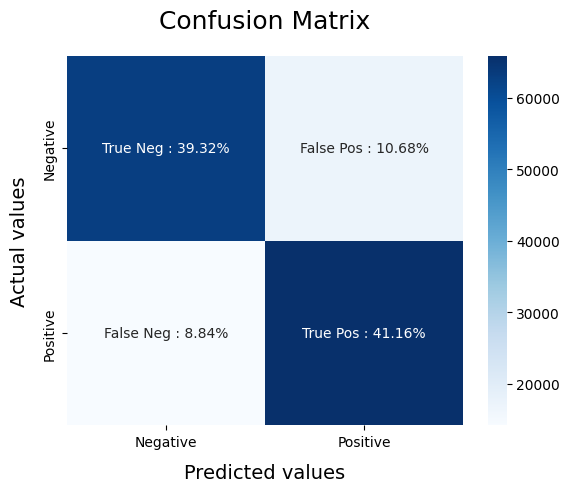

In [56]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


              precision    recall  f1-score   support

           0       0.82      0.79      0.80     80000
           1       0.80      0.82      0.81     80000

    accuracy                           0.81    160000
   macro avg       0.81      0.81      0.81    160000
weighted avg       0.81      0.81      0.81    160000



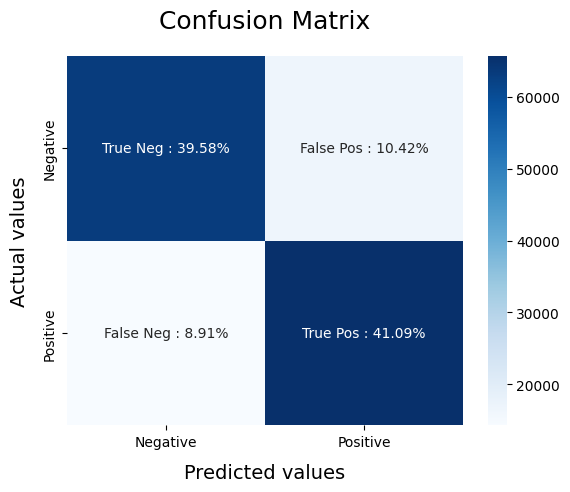

In [57]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)